In [1]:
import pandas as pd
import numpy as np
from geopy import distance
from matplotlib import pyplot as plt 

pd.options.mode.chained_assignment = None

In [2]:
# Read in CSV and do some preprocessing
df = pd.read_csv("penguin.csv")
df.dropna(inplace=True)
df.drop(columns=[
    "event-id", 
    "visible", # boolean indicating visibility, ignore False
    "migration-stage", 
    "tag-tech-spec", 
    "sensor-type",
    "individual-local-identifier", # individual id 
    "study-name",
    "individual-taxon-canonical-name" # species name 
    ], inplace=True)

df["timestamp"] = pd.to_datetime(df["timestamp"]) 
# used to simulate arrival times of penguins

# Seperate data by season
seasons = df["comments"].unique().tolist()

# Define nest location and boundary
nest_location = (-66.663596, 140.004067) 
radius = 1.0 # 1km away from nest 

In [3]:
""" Collect departure time for each season
    Use it as real-world event timestamps to:
    1. Derive empirical arrival rate funtion λ(t) for NSPP
    2. Ensure varied time rate model, realistic simulation 
"""
departure_time = []
for season in seasons:
    season_df = df[df["comments"] == season] # list of all individuals in a particular season
    penguin_ids = season_df["tag-local-identifier"].unique().tolist() # extract unique ids of individuals from season_df list

    years = season.split("-")
    years[0] = int(years[0])
    years[1] = int(years[1])

    # Look through all penguins 
    for id in penguin_ids:
        penguin_df = season_df[season_df["tag-local-identifier"] == id] # extract all rows of a particular individual id
        penguin_df.sort_values(by="timestamp", inplace=True)

        # coordinate tuple: current penguin first recorded location
        coord = (penguin_df["location-lat"].iloc[0], penguin_df["location-long"].iloc[0])
        # get distance between nest and penguin 
        for i in range(1, penguin_df.shape[0]):
            # iterate over all rows of the current penguin for location
            coord = (penguin_df["location-lat"].iloc[i], penguin_df["location-long"].iloc[i])
            cur_dist = distance.distance(nest_location, coord).km

            # If moved out of radius, add timestamp
            if i > 1 and prev_dist < radius and cur_dist >= radius:
                # capture time of the departure at current row i
                time = penguin_df["timestamp"].iloc[i]
                # parse year1 - year2 
                # set all year1 to 2000 and year2 to 2001
                # combine into a big list of only season 2000-2001
                if time.year == years[0]:
                    time.replace(year=2000)
                else:
                    time.replace(year=2001)
                
                departure_time.append(time)
                
                # then calculate interarrival time (between every timestamp)
                # determine the number of bins and size of bin [)
                # then make histogram with y-axis is the number of interarrivals in one bin 
               
            prev_dist = cur_dist
        
    
# sort departure times 
departure_time = np.array(departure_time)
departure_time = np.sort(departure_time)


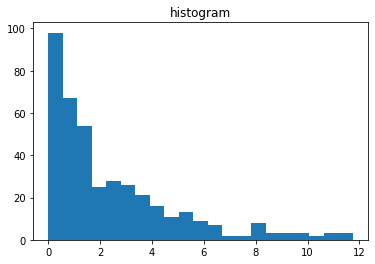

In [139]:
timestamps = np.zeros(departure_time.shape[0])
for i in range(departure_time.shape[0]):
    timestamps[i] = departure_time[i].timestamp()

inter_arrivals = np.diff(timestamps) / (60 * 60) # seconds to hours

# Reject inter arrival times more than 12 hours
def reject_outliers(data, m=2):
    data = data[data < 12]
    return data
    # return data[abs(data - np.mean(data)) < m * np.std(data)]

inter_arrivals_cleaned = reject_outliers(inter_arrivals)

num_bins = int(np.ceil(np.sqrt(inter_arrivals_cleaned.shape[0])))
bin_size = (max(inter_arrivals_cleaned) - min(inter_arrivals_cleaned)) / num_bins

bins = np.zeros(num_bins + 1)
bins[0] = min(inter_arrivals_cleaned)
for i in range(1, num_bins + 1):
    bins[i] = bins[i-1] + bin_size

hist, rbins = np.histogram(inter_arrivals_cleaned, bins)

plt.hist(inter_arrivals_cleaned, bins=bins) 
plt.title("histogram") 
plt.show()

In [140]:
sample_mean = np.mean(inter_arrivals_cleaned)
sample_std = np.std(inter_arrivals_cleaned, ddof=1)
num_tags = 129

def exponential_range(mean, left, right):
    return (
        (1-np.power(np.e, -mean*right)) - 
        (1-np.power(np.e, -mean*left))
    )

expected = np.zeros(num_bins)
for i in range(num_bins):
    expected[i] = (
        inter_arrivals_cleaned.shape[0] * 
        exponential_range(1/sample_mean, bins[i], bins[i+1])
    )

print(sample_mean)
print(hist)
print(expected)

# Calculate chi value
chi = 0
for i in range(num_bins):
    chi += np.power((hist[i] - expected[i]), 2) / expected[i]
    # print("adding", np.power((hist[i] - expected[i]), 2) / expected[i])

print("Chi:", chi)


2.421603410341034
[98 67 54 25 28 26 21 16 11 13  9  7  2  2  8  3  3  3  2  3  3]
[83.03882757 65.93168814 52.34885448 41.56427118 33.00146023 26.20270598
 20.80458852 16.51855743 13.11550764 10.41353286  8.26820201  6.56483879
  5.2123918   4.13856747  3.28596571  2.60901162  2.07151938  1.64475793
  1.30591519  1.03687872  0.82326746]
Chi: 32.50115141156997
